# Demand Forecasting using Deep Learning - LSTM (Long 'Short Term Memory')

LSTM is one of the prominent techniques under Recurrent Neural Netrowk which is known to remember long sequences over time.

### Can we mimic human behaviour of cash withdrawals using Deep Learning? Let's find out!

## 1. Setup
To prepare your environment, you need to install some packages.

### 1.1 Install the necessary packages

You need the latest versions of these packages:<br> We will be using Keras modules which runs on top of TensorFlow

In [1]:
import numpy as np 
import pandas as pd 
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.model_selection import  train_test_split
import math, time
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis
from pandas import read_csv
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from keras.models import model_from_json
import h5py
from keras.models import load_model
%matplotlib inline

Using TensorFlow backend.


# 1.2 Fix random seed for reproducibility

In [2]:
from numpy.random import seed
seed(1309)
from tensorflow import set_random_seed
set_random_seed(1309)

## 2. Read the Data & convert it into Dataframe
Click on Insert to code and then select Insert pandas DataFrame in the below empty cell.

In [3]:
df_data_1 = pd.read_csv(body)
df_data_1.head()

,Daily_Withdrawal_Amount
0,655600
1,643700
2,663500
3,692400
4,735200


# 3. Rename the dataframe and convert the datatype

In [4]:
series = df_data_1
series = series.astype(float)

# 4. Plot the data

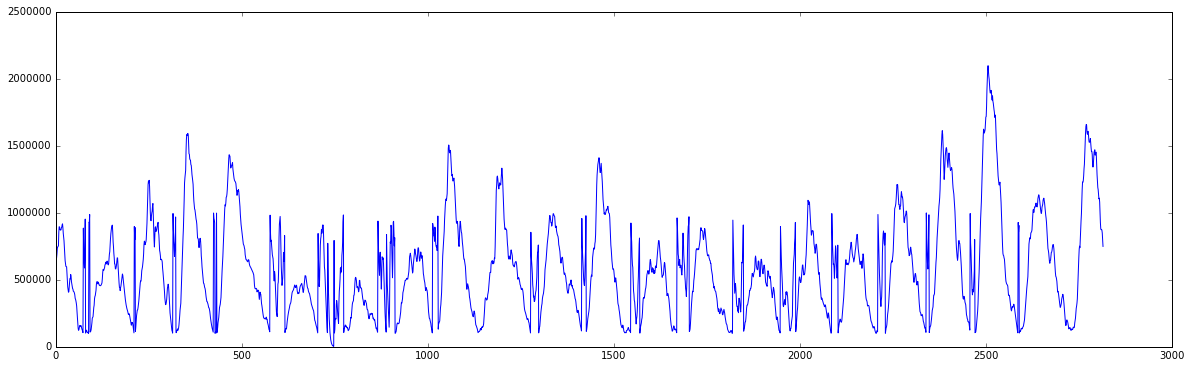

In [5]:
plt.figure(figsize=(20,6))
plt.plot(series.values)
plt.show()

We can observe, there's no trend and there is lot of variance.

# 5. Normalize the data

In [6]:
series = series.values
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)

# 6. Split the data into train and test with 80:20 ratio

In [7]:
train_size = int(len(series) * 0.80)
test_size = len(series) - train_size
train, test = series[0:train_size,:], series[train_size:len(series),:]
print(len(train), len(test))

2252 564


# 7. Convert an array into a dataset

In [8]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# 7.1 Create a dataset with a look back period of 20 observations

This is where we convert the time series problem into a regression problem

In [9]:
look_back = 20
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# 7.2 Review the shape of datasets

In [10]:
trainX.shape

(2231, 20)

In [11]:
testX.shape

(543, 20)

# 8. Reshape the data to 3D

The LSTM model requires the input data to be three dimensional

In [12]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [13]:
trainX.shape

(2231, 20, 1)

# 9. Define the LSTM model

Activation function will activate the neurons for the learning. Rectified linear unit (ReLu) is one of the most popular activations because the output does not go beyond 0.

Units will be the number of neurons in the input & hidden layers.

Stateful is where we define whether the previous information has to be remembered or not.

Dropout is where we omit random neurons for each layer as per the value (0 to 1). In this case we omit 20% of the neurons.

Optimiser is where the weights are back propagated through the network to enhance the learnings closer to the desired outcome. Adam optimiser is an efficient method for enhanced accuracy.

In [14]:
print('Build Model...')
model = Sequential()
model.add(LSTM(input_shape=(20,1), kernel_initializer="uniform", activation='relu', return_sequences=True, stateful=False, units=50))
model.add(Dropout(0.2))
model.add(LSTM(50, kernel_initializer="uniform", activation='relu',return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(32,kernel_initializer="uniform",activation='relu'))
model.add(Dense(1, activation='linear'))
#optimizer = Adam(lr=0.01)
#model.compile(loss="mse", optimizer=optimizer)
model.compile(loss="mse", optimizer='adam')
model.summary()

Build Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 32,265
Trainable params: 32,265
Non-trainable params: 0
_________________________________________________________

# 10. Params Calculation

params = 4 * (size_of_input + 1 * size_of_output) + 4 * size_of_output^2



# 11. Optimize computation time using early stopping

We monitor the accuracy of validation loss ('val_loss') and end the training if there's no improvement in the accuracy after five iterations ('patience=5').

In [15]:
'''One of the methods to optimize computation time'''

early_stopping=EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

# 11.1 Fitting the model for training data

In [16]:
start = time.time()
history = model.fit(trainX, trainY, batch_size=72, epochs=25, verbose=1, shuffle=False, validation_split=0.10, callbacks=[early_stopping])
print("> Compilation Time : ", time.time() - start)

Train on 2007 samples, validate on 224 samples
Epoch 1/25
2007/2007 [==============================] - 3s 1ms/step - loss: 0.0517 - val_loss: 0.0158
Epoch 2/25
2007/2007 [==============================] - 1s 494us/step - loss: 0.0206 - val_loss: 0.0125
Epoch 3/25
2007/2007 [==============================] - 1s 533us/step - loss: 0.0186 - val_loss: 0.0109
Epoch 4/25
2007/2007 [==============================] - 1s 529us/step - loss: 0.0149 - val_loss: 0.0098
Epoch 5/25
2007/2007 [==============================] - 1s 498us/step - loss: 0.0123 - val_loss: 0.0097
Epoch 6/25
2007/2007 [==============================] - 1s 498us/step - loss: 0.0117 - val_loss: 0.0092
Epoch 7/25
2007/2007 [==============================] - 1s 489us/step - loss: 0.0112 - val_loss: 0.0090
Epoch 8/25
2007/2007 [==============================] - 1s 590us/step - loss: 0.0101 - val_loss: 0.0086
Epoch 9/25
2007/2007 [==============================] - 1s 518us/step - loss: 0.0099 - val_loss: 0.0081
Epoch 10/25
2007/20

Model run time is ~ 30 seconds and has produced almost similar values for training & validation loss which is great.

# 11.2 Create a function to calculate accuracy

We will be using 'Mean Squared Error' & 'Root Mean Squared Error' functions to calculate accuracy

In [17]:
def model_score(model, trainX, trainY, testX, testY):
    trainScore = model.evaluate(trainX, trainY, batch_size=72, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))

    testScore = model.evaluate(testX, testY, batch_size=72, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))
    return trainScore, testScore

# 11.3 Check the Accuracy of the model

In [18]:
model_score(model, trainX, trainY, testX, testY)

Train Score: 0.00557 MSE (0.07 RMSE)
Test Score: 0.00485 MSE (0.07 RMSE)


(0.005567802917771626, 0.0048543642421680095)

We can observe that the Root Mean Squared Error (RMSE) values are almost similar for training & test data which confirms the accuracy of the model without overfitting or underfitting.

The model accuracy is > 94% as per the values of Mean Squared Error (MSE)

# 11.4 Review the learning of training & validation loss (error evaluation)

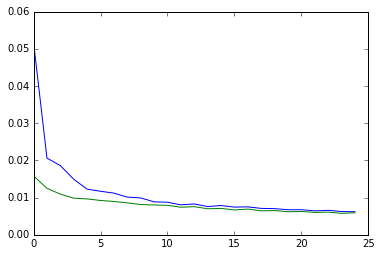

In [19]:
'''Review the learning'''

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

There's no vanishing gradient descent as the LSTM model with optimal configueration has taken care of the gradient descent problem.

# 11.5 Get the configuration of the model

This will give us an idea about all the parameters available and which ones have been choosen.

In [20]:
model.get_config()

[{'class_name': 'LSTM',
  'config': {'activation': 'relu',
   'activity_regularizer': None,
   'batch_input_shape': (None, 20, 1),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 1,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'RandomUniform',
    'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 50,
   'unroll': False,
   'use_bias': True}},
 {'class_name': 'Dropout',
 

In [21]:
'''Create a function to plot predicted vs actual values'''

def plot_the_results(predicted_data, true_data, prediction_len):
    fig = plt.figure(facecolor='white', figsize=(16,8))
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    for i, data in enumerate(predicted_data):
        padding = [None for p in range(i * prediction_len)]
        plt.plot(padding + data, label='Prediction')
        plt.plot(padding + data, 'b^')
    plt.show()

In [22]:
'''Create a function to predict future values'''

def predict_the_sequences(model, data, window_size, prediction_len):
    prediction_seqs = []
    for i in range(int(len(data)/prediction_len)):
        curr_frame = data[i*prediction_len]
        predicted = []
        for j in range(prediction_len):
            predicted.append(model.predict(curr_frame[newaxis,:,:])[0,0])
            curr_frame = curr_frame[1:]
            curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
        prediction_seqs.append(predicted)
    return prediction_seqs

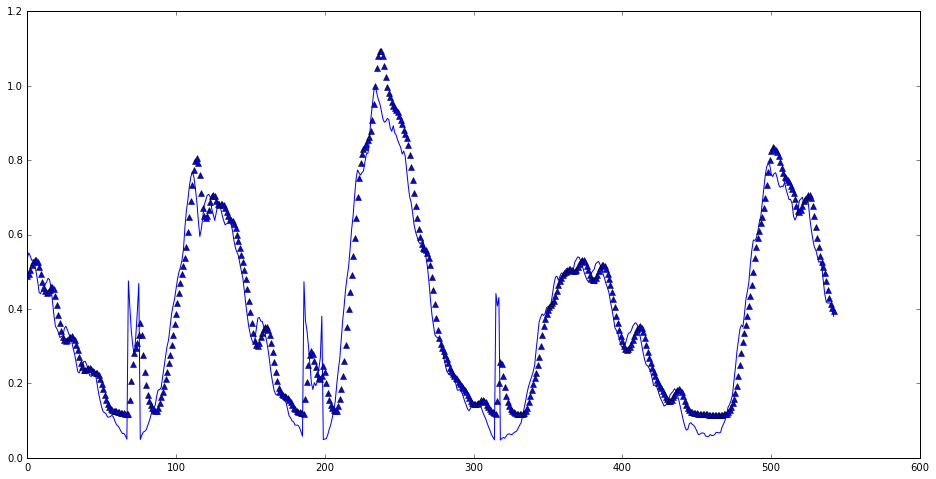

In [23]:
'''Predict future values & plot the results
   In this case, we are predicting the current values.
   If we need to predict t+1 then the prediction_len parameter has to be changed to 2
   and if we need t+2 then prediction_len would be 3'''

predictions = predict_the_sequences(model, testX, 20, 1)

plot_the_results(predictions, testY, 1)

We can observe that the model is able to catch the pattern in the data. This can be further improved by changing the hyper parameters however we are demonstrating the methodology.

## Cross Validation Technique for testing the accuracy on different training samples. 

### This is computationally intensive and should be performed on a GPU.

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score

def build_classifier():
    model = Sequential()
    model.add(LSTM(input_shape=(20,1), kernel_initializer="uniform", activation='relu', return_sequences=True, stateful=False, units=50))
    model.add(Dropout(0.2))
    model.add(LSTM(50, kernel_initializer="uniform", activation='relu',return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))
    model.add(Dense(1, activation='linear'))
    model.compile(optimizer='adam', loss = "mse")
    model.fit(trainX, trainY)
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 72, epochs = 100)
accuracies = cross_val_score(estimator = classifier, X = trainX, y = trainY, cv = 10, n_jobs = -1)
mean = accuracies.mean()
variance = accuracies.std()

# Finding the best values for hyper parameters

### This is again computationally intensive and should be performed on GPU

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense

classifier = KerasClassifier(build_fn = build_classifier)
parameters = {'batch_size': [42, 62, 82],
              'epochs': [50, 75, 100],
              'optimizer': ['adam', 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10)
grid_search = grid_search.fit(trainX, trainY)
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

In [24]:
'''Denormalize the predicted values and review.
   Convert the predicted output to a dataframe & print the results'''

predictions = scaler.inverse_transform(predictions)
results = pd.DataFrame(np.round(predictions[-10:]))
print(results)

           0
0  1141589.0
1  1106555.0
2  1078518.0
3  1043567.0
4   998324.0
5   948444.0
6   904360.0
7   871119.0
8   847975.0
9   830436.0


## Follow the earlier steps with multiple iterations by changing the hyperparameters for better understanding of the flow.

We can use model.save(filepath) to save a Keras model into a single HDF5 file which will contain:

The architecture of the model, allowing to re-create the model.

The weights of the model.

The training configuration (loss, optimizer).

The state of the optimizer, allowing to resume training exactly where you left off.

# 12. Transfer Learning

Save the model for future use on new data

## Methodology of saving the model to object storage or file system is out of scope of this pattern. It is assumed that the user would know how to save Keras model to object storage.

In [27]:
model.save('filepath/my_model.h5')
print('Model saved to disc')

Model saved to disc


# 12.1 Load the model

In [28]:
model = load_model('filepath/my_model.h5')
print('Model loaded to the session')

Model loaded to the session


In [29]:
'''Read new data & rename the dataframe'''

print(df_data_2.head())
print(df_data_2.shape)

new_series = df_data_2
new_series = new_series.astype(float)
new_series.isnull().any()

   Daily_Withdrawal_Amount
0                   910000
1                   132200
2                   110500
3                   987100
4                   764200
(98, 1)


Daily_Withdrawal_Amount    False
dtype: bool

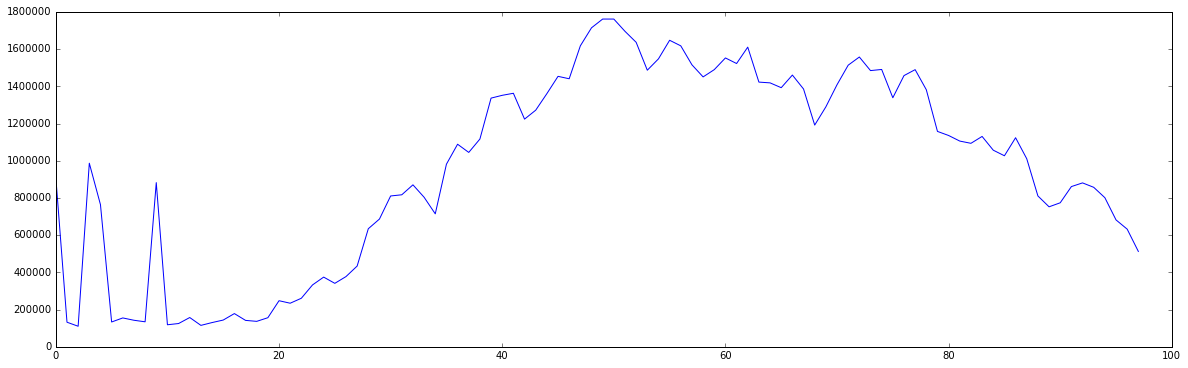

In [30]:
'''Plot the data'''

plt.figure(figsize=(20,6))
plt.plot(new_series.values)
plt.show()

In [31]:
'''Normalize the data'''

scaler = MinMaxScaler(feature_range=(0, 1))
new_data = scaler.fit_transform(new_series)
print(len(new_data))

98


# Reshape the data and create the dataframe

Note : We are not doing train and test split, instead we are feeding the entire new data to the trained model. 

In [32]:
look_back = 20
new_testX, new_testY = create_dataset(new_data, look_back)

In [33]:
new_testX = np.reshape(new_testX, (new_testX.shape[0], new_testX.shape[1], 1))

In [34]:
new_testX.shape

(77, 20, 1)

# Optimize computation time using early stopping

In [35]:
early_stopping=EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')

In [36]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1632      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 32,265
Trainable params: 32,265
Non-trainable params: 0
_________________________________________________________________


# We are fitting the existing model on the new data using Transfer Learning where the learnings from previous data will be applied on the new data

In [37]:
start = time.time()
model.fit(new_testX, new_testY, batch_size=72, epochs=20, verbose=1, shuffle=False, validation_split=0.05, callbacks=[early_stopping])
print("> Compilation Time : ", time.time() - start)

Train on 73 samples, validate on 4 samples
Epoch 1/20
73/73 [==============================] - 1s 10ms/step - loss: 0.0149 - val_loss: 0.0027
Epoch 2/20
73/73 [==============================] - 0s 1ms/step - loss: 0.0177 - val_loss: 0.0035
Epoch 3/20
73/73 [==============================] - 0s 1ms/step - loss: 0.0143 - val_loss: 0.0028
Epoch 4/20
73/73 [==============================] - 0s 1ms/step - loss: 0.0113 - val_loss: 0.0031
Epoch 5/20
73/73 [==============================] - 0s 1ms/step - loss: 0.0093 - val_loss: 0.0058
Epoch 6/20
73/73 [==============================] - 0s 1ms/step - loss: 0.0131 - val_loss: 0.0058
Epoch 7/20
73/73 [==============================] - 0s 973us/step - loss: 0.0122 - val_loss: 0.0045
Epoch 8/20
73/73 [==============================] - 0s 1ms/step - loss: 0.0108 - val_loss: 0.0046
Epoch 9/20
73/73 [==============================] - 0s 1ms/step - loss: 0.0123 - val_loss: 0.0053
Epoch 10/20
73/73 [==============================] - 0s 2ms/step - loss:

In [38]:
'''Function to calculate accuracy
   Here, we are using three parameters to create the function'''

def model_score_new(model, new_testX, new_testY):
    NewModelScore = model.evaluate(new_testX, new_testY, batch_size=72, verbose=0)
    print('NewModel Score: %.5f MSE (%.2f RMSE)' % (NewModelScore, math.sqrt(NewModelScore)))
    return NewModelScore

In [39]:
'''Test the accuracy'''

model_score_new(model, new_testX, new_testY)

NewModel Score: 0.00657 MSE (0.08 RMSE)


0.006567829034545205

# We can observe that the model performed even better on the new data with great accuracy.

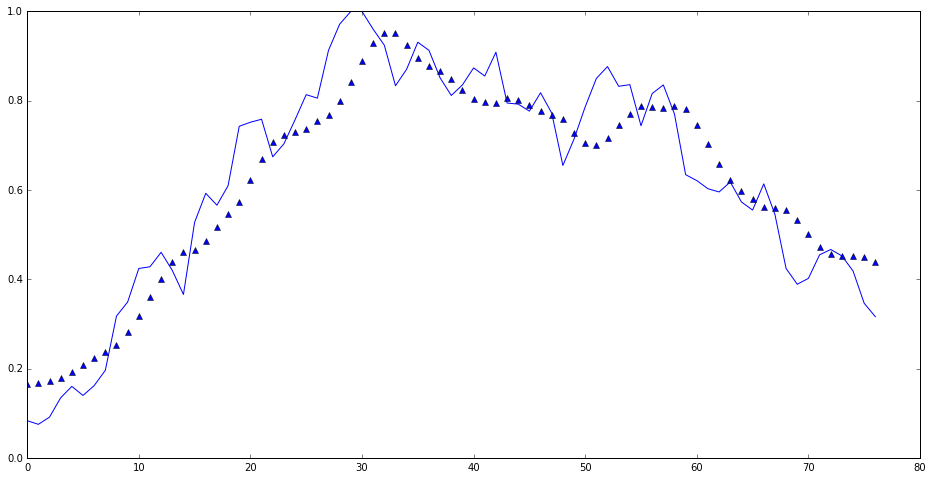

In [40]:
'''Predict future values and plot the results'''

predictions = predict_the_sequences(model, new_testX, 20, 1)

plot_the_results(predictions, new_testY, 1)

The model is able to identify and replicate the pattern in the data.

We can denormalize the predicted values and print as shown earlier.

# Methodology to save the model's architecture and weights for reusability in the future
We can use these weights alone which has the learnings on other data.

In [41]:
model_json = model.to_json()
with open("filepath/model.json", "w") as json_file:
    json_file.write(model_json)

model.save_weights("filepath/model.h5")
print("Saved model to disk")

Saved model to disk


# By loading the model architecture, we can rebuild the model with different configuration

We can also use the existing weights on the new architecture.

In [42]:
json_file = open('filepath/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)


loaded_model.load_weights("filepath/model.h5")
print("Loaded model from disk")

Loaded model from disk


# Since we loaded the architecture & weights, we need to compile the model

In [43]:
loaded_model.compile(loss="mse", optimizer="adam")

In [44]:
early_stopping=EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')

# Fit the new loaded model on the data to churn out forecasts

In [45]:
start = time.time()
loaded_model.fit(new_testX, new_testY, batch_size=72, epochs=15, verbose=1, shuffle=False, validation_split=0.05, callbacks=[early_stopping])
print("> Compilation Time : ", time.time() - start)

Train on 73 samples, validate on 4 samples
Epoch 1/15
73/73 [==============================] - 2s 29ms/step - loss: 0.0123 - val_loss: 0.0068
Epoch 2/15
73/73 [==============================] - 0s 1ms/step - loss: 0.0090 - val_loss: 0.0039
Epoch 3/15
73/73 [==============================] - 0s 849us/step - loss: 0.0107 - val_loss: 0.0053
Epoch 4/15
73/73 [==============================] - 0s 973us/step - loss: 0.0136 - val_loss: 0.0126
Epoch 5/15
73/73 [==============================] - 0s 932us/step - loss: 0.0156 - val_loss: 0.0109
Epoch 6/15
73/73 [==============================] - 0s 808us/step - loss: 0.0141 - val_loss: 0.0056
Epoch 00006: early stopping
> Compilation Time :  5.497314453125


Early stopping function ha stopped the training for ~ 6 epochs as there was no improvement in the validation loss values.

In [46]:
'''Evaluate accuracy'''

model_score_new(model, new_testX, new_testY)

NewModel Score: 0.00657 MSE (0.08 RMSE)


0.006567829034545205

Again, the model has displayed great accuracy.

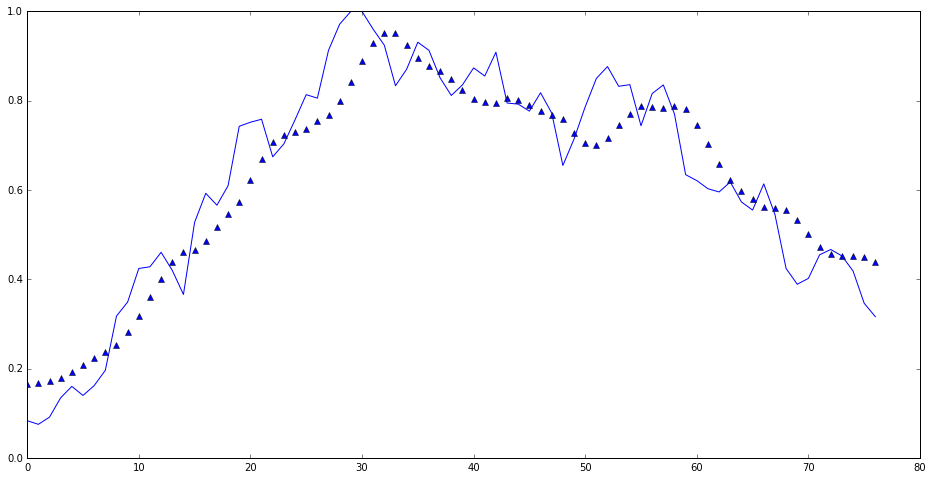

In [47]:
'''Predict future values & plot the results'''

predictions = predict_the_sequences(model, new_testX, 20, 1)

plot_the_results(predictions, new_testY, 1)

### We can sume up the learnings of LSTM and its advantages. We have learned how to create and deploy a deep learning model, use transfer learning for testing on new data, save the model, architecture & weights for future use. We have also learned how to evaluate the model & tune the parameters. LSTM is a very popular technique which can be applied to different usecases and can produce great results. 